In [1]:
import os 

import torch 
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms

from tqdm.auto import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

from nn_module import DML, arcface_loss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
down_width = 360  
down_height = 360 

images = []
targets = []
folder_names = os.listdir('test_data')

class_targets = dict(zip(folder_names, range(len(folder_names))))
 
for folder in folder_names:
    for img_name in os.listdir(f'test_data/{folder}'):
        img1 = cv2.imread(f'test_data/{folder}/{img_name}')
        img1 = torch.FloatTensor(cv2.resize(img1, (down_width, down_height), interpolation=cv2.INTER_LINEAR))
        images.append(img1.unsqueeze(0))
        targets.append(class_targets[folder])

images = torch.cat(images, axis=0)
images = images.permute(0, 3, 1, 2)
targets = torch.LongTensor(targets)

In [4]:
n_classes = len(class_targets)

data_size = images.shape[0]
train_size = 0.7

all_idx = torch.randperm(data_size)
train_idx = all_idx[:int(data_size*train_size)]
test_idx = all_idx[int(data_size*train_size):]

train_data = TensorDataset(images[train_idx], targets[train_idx]) 
test_data = TensorDataset(images[test_idx], targets[test_idx])

train_data_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [5]:
model = DML(embedding_size=128, n_classes=n_classes)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.7)

loss_history = []

c:\Users\nikol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
lr = 1e-3
n_epochs = 100
batch_n = len(train_data_loader)

for g in optim.param_groups:
    g['lr'] = lr

model.train()
for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch in train_data_loader:
        optim.zero_grad()
        
        predict = model(batch[0].to(device))
        loss = arcface_loss(predict, batch[1].to(device), n_classes=n_classes)
        
        loss.backward()
        optim.step()
        
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        
    print_loss_bool = (epoch+1)%(n_epochs//10) == 0 if n_epochs > 10 else True
    if print_loss_bool:
        print(f'Loss: {epoch_loss/batch_n:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2567
Loss: 1.1179
Loss: 1.0937
Loss: 1.0852
Loss: 1.0539
Loss: 1.0715
Loss: 1.0492
Loss: 1.0340
Loss: 1.0493
Loss: 1.0332


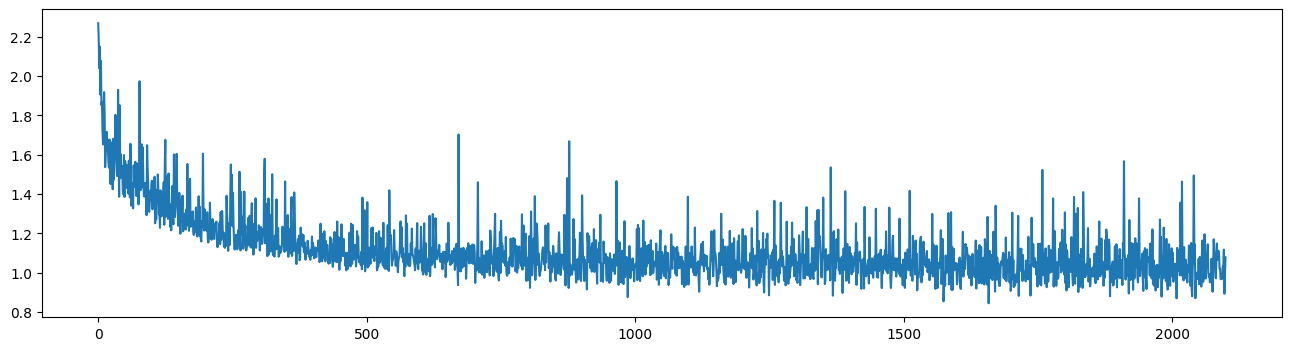

In [7]:
plt.figure(figsize=(16,4))
plt.plot(loss_history)

In [8]:
train_predict, train_targets = model.get_predict(train_data_loader, device)
test_predict, test_targets = model.get_predict(test_data_loader, device)

train_targets = train_targets.cpu()
test_targets = test_targets.cpu()

train_predict_targets = torch.argmax(train_predict, dim=1).cpu()
test_predict_targets = torch.argmax(test_predict, dim=1).cpu()

In [9]:
from sklearn.metrics import balanced_accuracy_score

In [10]:
print(f'Train BA: {balanced_accuracy_score(train_targets.cpu(), train_predict_targets)}')
print(f'Test BA: {balanced_accuracy_score(test_targets.cpu(), test_predict_targets)}')

Train BA: 1.0
Test BA: 0.6570947570947571


In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    }, 'model.pt')

-----